# Sequential Monte Carlo

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.1


In [2]:
az.style.use('arviz-darkgrid')

Sampling from distributions with multiple peaks with a standard MCMC methods can be difficult, if not impossible, as the Markov chain often gets stuck in either of the minima. A Sequential Monte Carlo sampler (SMC) is a way to ameliorate this problem. SMC samplers are very similar to genetic algorithms, which are biologically-inspired algorithms that can be summarized as follows:

1. Initialization: set a population of individuals
2. Mutation: individuals are somehow modified or perturbed
3. Selection: individuals with high _fitness_ have higher chance to generate _offspring_.
4. Iterate by using individuals from 3 to set the population in 1.

If each _individual_ is a particular solution to a problem, then a genetic algorithm will eventually produce good solutions to that problem. One key aspect is to generate enough diversity (mutation step) to explore the solution space avoiding getting trap in local minima and then apply _selection_ to _probabilistically_ keep reasonable solutions while also keeping some diversity. Being too greedy and short-sighted could be problematic, _bad_ solutions in a given moment could lead to _good_ solutions in the future.

Moving into the realm of Bayesian statistics each individual is a point in the _posterior space_, mutations can be done in several ways, a general solution is to use a MCMC method (like Metropolis-Hastings or NUTS) and run many Markov chains in parallel. The _fitness_ is given by the posterior, points with low posterior density will be removed and points high posterior density will be used as the starting point of a next round of Markov chains (This step is known as _reweighting_ in the SMC literature). The size of the population is kept fixed at some predefined value, so if a point is removed some other point should be used to start at least two new Markov chains.

The previous paragraph is summarized in the next figure, the first subplot shows 5 samples (orange dots) at some particular stage. The second subplot shows how these samples are reweighted according to their posterior density (blue Gaussian curve). The third subplot shows the result of running a certain number of Metropolis steps, starting from the selected/reweighted samples in the second subplot, notice how the two samples with the lower posterior density (smaller circles) are discarded and not used to seed Markov chains.

![SMC stages](https://github.com/pymc-devs/pymc3/raw/master/docs/source/notebooks/smc.png)

So far we have that the SMC sampler is just a bunch of parallel Markov chains, not very impressive, right? Well not that fast. SMC proceed by moving _sequentially_ through a series of stages, starting from a easy to sample distribution until it get to the posterior distribution. All these intermediate distributions (or _tempered posterior distributions_) are controlled by a _tempering_ parameter called $\beta$. SMC takes this idea from other _tempering_ methods originated from a branch of physics known as _statistical mechanics_. The idea is as follow, the number of accessible states a _real physical_ system can reach is controlled by the temperature, if the temperature is the lowest possible ($0$ Kelvin) the system is trapped in a single state, on the contrary if the temperature is $\infty$ all states are equally accessible! In the _statistical mechanics_ literature $\beta$ is know as the inverse temperature, the higher the more constrained the system is. Going back to the Bayesian statistics context a _natural_ analogy to physical systems is given by the following formula:

$$p(\theta \mid y)_{\beta} \propto p(y \mid \theta)^{\beta} p(\theta)$$

When $\beta = 0$, the _tempered posterior_ is the prior and when $\beta=1$ the _tempered posterior_ is the true posterior. SMC starts with $\beta = 0$ and progress by always increasing the value of $\beta$, at each stage, until it reach 1. As $\beta$ increase the tempered posterior concetrates more and more. This is represented in the avobe figure by a narrower Gaussian distribution in the third subplot.

For the SMC version implemented in PyMC3 the number of parallel chains (or individuals) is the number of draws. At each stage SMC will use independent Markov chains to explore the _tempered posterior_ (the black arrow in the figure). The final samples, _i.e_ those stored in the `trace`, will be taken exclusively from the final stage ($\beta = 1$), i.e. the true posterior.

The successive values of $\beta$ are determined automatically. The harder the distribution is to sample the closer two succesive values of $\beta$ will be. And the larger the number of stages SMC will take. SMC computes the next $\beta$ value by keeping the effective sample size (ESS) between two stages at a constant predefined value of half the number of draws. This can adjusted if necessary by the `threshold` parameter (in the interval [0, 1]), the default value of 0.5 have being found to be a good default, the larger this value the higher the target-ESS and the smaller the differences two succesive values of $\beta$ will be. This ESS value is computed from the importance weights and not from the autocorrelation like those from ArviZ (for example using `az.ess` or `az.summary`). 

Two more parameters that are automatically determined are:
* The number of steps each Markov chain takes to explore the _tempered posterior_ `n_steps`. This is determined from the acceptance rate from the previous stage.
* The (co)variance of the (Multivariate)Normal proposal distribution is also adjusted adaptively based on the  acceptance rate at each stage.


Even when SMC uses the Metropolis-Hasting algorithm under the hood, it has several advantages over it:

* It can sample from distributions with multiple peaks.
* It does not have a burn-in period, it starts by sampling directly from the prior and then at each stage the starting points are already _approximately_ distributed according to the tempered posterior (due to the re-weighting step).
* It is inherently parallel (PyMC4 will take better advantage of this feature).

To see an example of how to use SMC inside PyMC3 let's define a multivariate gaussian of dimension $n$, their weights and the covariance matrix. 

In [3]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

The PyMC3 model.  Note that we are making two gaussians, where one has `w1` (90%) of the mass:

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])


with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    trace = pm.sample_smc(2000, parallel=True)

Initializing SMC sampler...
Multiprocess sampling (2 chains in 2 jobs)
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.140
Stage:   4 Beta: 0.299
Stage:   5 Beta: 0.619
Stage:   6 Beta: 1.000


Plotting the results using the plot_trace:

/home/osvaldo/proyectos/00_BM/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/osvaldo/proyectos/00_BM/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


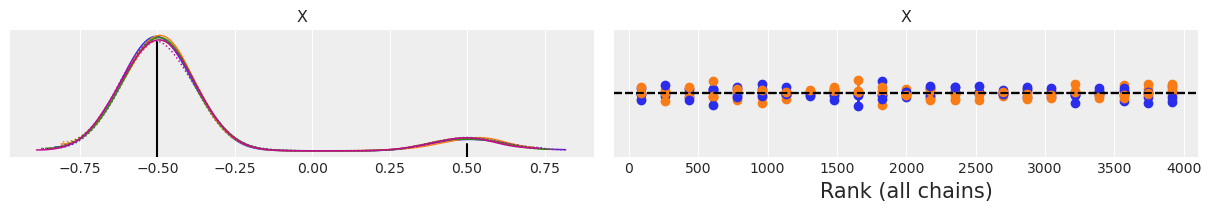

In [5]:
ax = az.plot_trace(trace, compact=True, kind="rank_vlines");
ax[0, 0].axvline(-0.5, 0, .9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")

From the kde we can see that we recover the modes and even the relative weights seems preety good. The rank plot on the right looks good, the vertical lines are very close to the reference black-dashed line.

SMC (with a Metropolis kernel) is not free of problems, as it relies on Metropolis it will deteriorate as the dimensionality of the problem increases and/or if the geometry of the posterior is _weird_ as in hierarchical models. To some extent increasing the number of draws and maybe the number of `n_steps`. To access the number of steps per stage you can check `trace.report.nsteps`. Ideally SMC will take a number of steps lower than `n_steps`.

Let's make SMC fails spectacularly. We will run the same model, but increasing the dimensionality from 4 to 40.

In [6]:
n = 40

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1
w2 = (1 - w1)

The PyMC3 model.  Note that we are making two gaussians, where one has `w1` (90%) of the mass:

In [7]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])


with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    trace = pm.sample_smc(2000, parallel=True)

Initializing SMC sampler...
Multiprocess sampling (2 chains in 2 jobs)
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.007
Stage:   3 Beta: 0.010
Stage:   4 Beta: 0.013
Stage:   5 Beta: 0.017
Stage:   6 Beta: 0.021
Stage:   7 Beta: 0.026
Stage:   8 Beta: 0.033
Stage:   9 Beta: 0.042
Stage:  10 Beta: 0.053
Stage:  11 Beta: 0.067
Stage:  12 Beta: 0.082
Stage:  13 Beta: 0.099
Stage:  14 Beta: 0.122
Stage:  15 Beta: 0.153
Stage:  16 Beta: 0.192
Stage:  17 Beta: 0.240
Stage:  18 Beta: 0.302
Stage:  19 Beta: 0.381
Stage:  20 Beta: 0.475
Stage:  21 Beta: 0.584
Stage:  22 Beta: 0.706
Stage:  23 Beta: 0.857
Stage:  24 Beta: 1.000


We see that SMC, recognizes this is a harder problem and increase the number of stages. Unfortunatelly in this case that is not enought to recover the correct posterior as we can see in the following plot (pay special attention to the rank plot).

/home/osvaldo/proyectos/00_BM/arviz/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


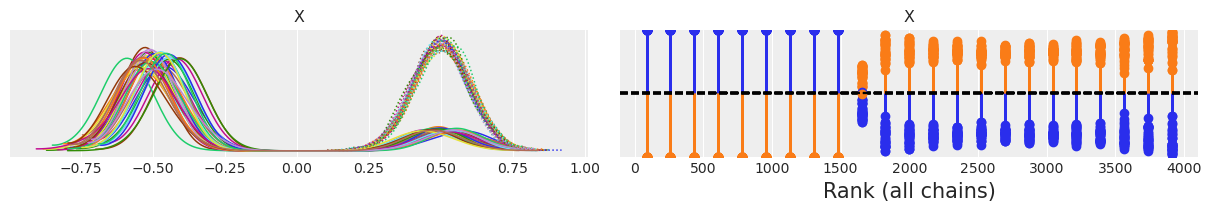

In [8]:
az.plot_trace(trace, compact=True, kind="rank_vlines");

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy    1.18.1
pymc3    3.9.1
autopep8 1.5
arviz    0.8.3
json     2.0.9
last updated: Fri Jun 26 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.2
